In [1]:
import pandas as pd
import ast
# Read the file line-by-line
with open("bike_data.csv", "r") as f:
    lines = f.readlines()[1:]  # skip header

# Extract the part after the comma and parse as dictionary
records = []
for line in lines:
    try:
        raw_dict = line.split(",", 1)[1].strip().strip('"')
        parsed_dict = ast.literal_eval(raw_dict)
        records.append(parsed_dict)
    except Exception as e:
        print(f"Skipping line due to error: {e}")

# Convert list of dicts to DataFrame
df = pd.DataFrame(records)
print(df.isna().sum())

# Convert timestamps to datetime
df['start_time'] = pd.to_datetime(df['start_time'], unit='ms')
df['hour']= df['start_time'].dt.hour
df['weekday'] = df['start_time'].dt.day_name()
df['end_time'] = pd.to_datetime(df['end_time'], unit='ms')
df['timestamps_list'] = df["timestamps_list"].apply(
    lambda x: pd.to_datetime(x, unit='ms')
)
df.head()

trip_id             0
end_time            0
coordinates         0
vehicle_type        0
accuracy            0
trip_distance       0
propulsion_types    0
SID                 0
start_time          0
timestamps_list     0
trip_duration       0
vehicle_id          0
timestamp           0
_headers            0
dtype: int64


,trip_id,end_time,coordinates,vehicle_type,accuracy,trip_distance,propulsion_types,SID,start_time,timestamps_list,trip_duration,vehicle_id,timestamp,_headers,hour,weekday
0,439f9229-2784-4338-9773-d652c9e568cc,2023-07-31 23:04:03.510,"[[8.262563, 50.000889], [8.262563, 50.000889],...",scooter,8.0,1926.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 22:57:07.199,"DatetimeIndex(['2023-07-31 22:57:07', '2023-07...",416.0,403328,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},22,Monday
1,c55453e0-b755-4158-9d78-d333097ecb45,2023-07-31 23:11:14.877,"[[8.227722, 49.996441], [8.22736, 49.996296], ...",scooter,8.0,2294.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 23:02:56.447,"DatetimeIndex(['2023-07-31 23:02:56', '2023-07...",498.0,420400,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},23,Monday
2,916c12fa-965e-4902-a92f-e4804944093b,2023-07-31 23:45:57.514,"[[8.267058, 49.984197], [8.267061, 49.984202],...",scooter,8.0,3689.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 23:29:08.466,"DatetimeIndex(['2023-07-31 23:29:08', '2023-07...",1009.0,419482,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},23,Monday
3,62efe364-30f4-4f48-b80a-d6c193dcdf86,2023-07-31 23:15:54.405,"[[8.259436, 50.005557], [8.259816, 50.0054], [...",scooter,8.0,2613.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 23:06:23.757,"DatetimeIndex(['2023-07-31 23:06:23', '2023-07...",571.0,415192,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},23,Monday
4,9140fcef-3652-4b25-80b9-2304c4a3b6da,2023-07-31 23:13:33.966,"[[8.279259, 49.996319], [8.279267, 49.996318],...",scooter,8.0,1538.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 23:08:14.374,"DatetimeIndex(['2023-07-31 23:08:14', '2023-07...",320.0,421106,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},23,Monday


In [2]:
import numpy as np
from folium import Map, Rectangle
# Extract all coordinates into a single list
all_coords = []
for coords in df['coordinates']:
    all_coords.extend(coords)

# Convert to a NumPy array for easier calculations
all_coords = np.array(all_coords)  # shape: (N, 2) where N = total points

# Calculate min/max lat and lon
min_lon, max_lon = np.min(all_coords[:, 0]), np.max(all_coords[:, 0])
min_lat, max_lat = np.min(all_coords[:, 1]), np.max(all_coords[:, 1])

area_center = (np.mean([min_lat, max_lat]), np.mean([min_lon, max_lon]))
m = Map(location=area_center, zoom_start=10)
Rectangle(
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    color='red',
    fill=True
).add_to(m)
m.save("area_check.html")

Bin 0–600 sec: 2797663.0 intervals (99.98%)
Bin 600–1200 sec: 285.0 intervals (0.01%)
Bin 1200–1800 sec: 84.0 intervals (0.00%)
Bin 1800–2400 sec: 46.0 intervals (0.00%)
Bin 2400–3000 sec: 18.0 intervals (0.00%)
Bin 3000–3600 sec: 5.0 intervals (0.00%)
Bin 3600–4200 sec: 1.0 intervals (0.00%)


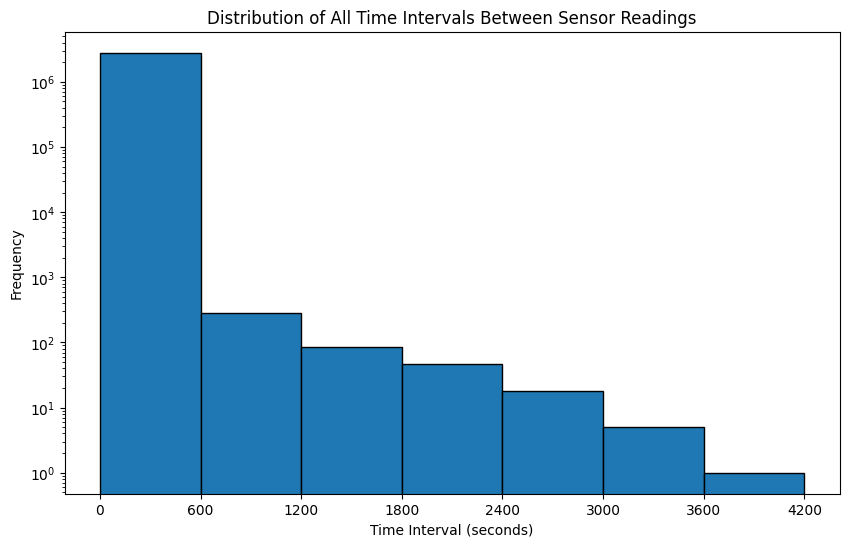

In [3]:
import matplotlib.pyplot as plt 

# Function to calculate time intervals between consecutive timestamps
def calculate_time_intervals(timestamps):
    if len(timestamps) < 2:
        return []
    intervals = np.diff(timestamps).astype('timedelta64[ms]').astype(int) / 1000  # Convert to seconds
    return intervals

# Apply the function to each trip
df['time_intervals'] = df['timestamps_list'].apply(calculate_time_intervals)

# Plot histogram of all intervals (flattened)
all_intervals = np.concatenate(df['time_intervals'].values)
plt.figure(figsize=(10, 6))
custom_bins=[0,600,1200,1800,2400,3000,3600,4200,]
counts, bins, patches = plt.hist(all_intervals, bins=custom_bins, edgecolor='black', density=False)
for i in range(len(counts)):
    left = int(bins[i])
    right = int(bins[i+1])
    percentage = counts[i] / np.sum(counts) * 100
    print(f"Bin {left}–{right} sec: {counts[i]} intervals ({percentage:.2f}%)")
plt.xticks(bins.astype(int))
plt.yscale('log')
plt.title('Distribution of All Time Intervals Between Sensor Readings')
plt.xlabel('Time Interval (seconds)')
plt.ylabel('Frequency')
plt.show()



Text(0.5, 1.0, 'Distribution of Routes by Hour of Day')

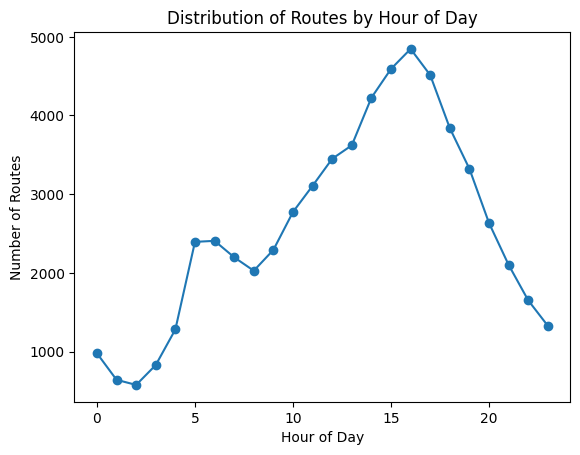

In [4]:
hourly_counts = df['hour'].value_counts().sort_index()
hourly_counts.plot(kind='line', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Routes')
plt.title('Distribution of Routes by Hour of Day')

Text(0.5, 1.0, 'Distribution of Routes by Weekday')

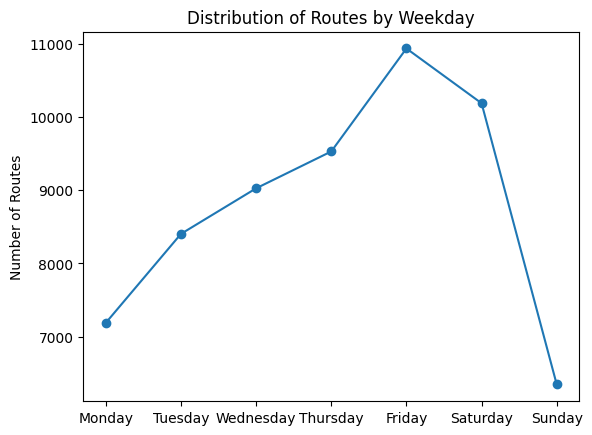

In [5]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['weekday'].value_counts().reindex(weekday_order)
weekday_counts.plot(kind='line', marker='o')
plt.xlabel('')
plt.ylabel('Number of Routes')
plt.title('Distribution of Routes by Weekday')

In [6]:
from folium.plugins import HeatMap
from geopy.distance import geodesic

def interpolate_coords(p1, p2, step_meters=50):
    dist = geodesic((p1[1], p1[0]), (p2[1], p2[0])).meters
    n_steps = max(1, int(dist / step_meters))
    return [
        [
            p1[1] + (p2[1] - p1[1]) * i / n_steps,
            p1[0] + (p2[0] - p1[0]) * i / n_steps
        ]
        for i in range(n_steps + 1)
    ]

all_coords = []

for coords in df['coordinates']:
    if not coords or len(coords) < 2:
        continue

    for i in range(len(coords) - 1):
        inter_coords = interpolate_coords(coords[i], coords[i + 1])
        # Remove the duplicate at the segments junction 
        if i > 0:
            inter_coords = inter_coords[1:]

        all_coords.extend(inter_coords)

m = Map(location=area_center, zoom_start=10)
HeatMap(all_coords, radius=8).add_to(m)
m.save("heatmap.html")

In [7]:
from folium.plugins import HeatMapWithTime

grouped = df.groupby("weekday")

heatmap_data = []
week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for day in week_order:
    raw_coords = []

    for coords in grouped.get_group(day)["coordinates"]:
        if not coords or len(coords) < 2:
            continue

        for i in range(len(coords) - 1):
            inter_coords = interpolate_coords(coords[i], coords[i + 1])
            if i > 0:
                inter_coords = inter_coords[1:]

            raw_coords.extend(inter_coords)

    # Add weight to each point
    if raw_coords:
        weight = 1 / len(raw_coords)
        day_coords = [[lat, lon, weight] for lat, lon in raw_coords]
    else:
        day_coords = []

    heatmap_data.append(day_coords)

m = Map(location=area_center, zoom_start=13)
HeatMapWithTime(
    data=heatmap_data,
    index=week_order,
    radius=8,
    max_opacity=0.6,
).add_to(m)

m.save("heatmap_weekdays.html")

In [8]:
grouped = df.groupby("hour")

heatmap_data = []
hour_labels = [f"{h:02d}:00" for h in range(24)]

for hour in range(24):
    raw_coords = []
    for coords in grouped.get_group(hour)["coordinates"]:
        if not coords or len(coords) < 2:
            continue

        for i in range(len(coords) - 1):
            inter_coords = interpolate_coords(coords[i], coords[i + 1])
            # Remove the duplicate at the segments junction 
            if i > 0:
                inter_coords = inter_coords[1:]

            raw_coords.extend(inter_coords)
    
    if raw_coords:
        weight = 1 / len(raw_coords)
        hour_coords = [[lat,lon, weight] for lat, lon in raw_coords]
    else:
        hour_coords = []
    heatmap_data.append(hour_coords)

m = Map(location=area_center, zoom_start=13)
HeatMapWithTime(
    data=heatmap_data,
    index=hour_labels,
    radius=8,
    max_opacity=0.6
).add_to(m)

m.save("heatmap_hours.html")